# Predicting Server Power Usage

This is my showcase for @WalmartLabs System Engineering Intern Summer 2018
## Dataset

Data Source: From the authors of paper https://www.usenix.org/legacy/event/hotpower08/tech/full_papers/rivoire/rivoire.pdf

## Description of Variables

The dataset contains 31272 observations of 10 variables:
* `_time`:  time of measurement
* `ac_power`: AC Power usage
* `total-unhalted_core_cycles`: as its name
* `total-instructions_retired`: as its name
* `total-last_level_cache_references`: as its name
* `total-memory_bus_transactions`: as its name
* `total-cpu-utilization`: as its name
* `total-disk-accesses`: as its name
* `total-disk-blocks`: as its name
* `total-disk-utilization`: as its name

## Problem Statement

I want to predict the power utilization of a machine based on other machine metrics such as CPU utilization and memory transactions.

## Import modules

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## Data Pre-Processing

First, let's load the dataset and do some "touch"

In [202]:
# load dataset
df = pd.read_csv("data/server_power.csv")
print df.columns
print df.count()

Index([u'_time', u'ac_power', u'total-unhalted_core_cycles',
       u'total-instructions_retired', u'total-last_level_cache_references',
       u'total-memory_bus_transactions', u'total-cpu-utilization',
       u'total-disk-accesses', u'total-disk-blocks',
       u'total-disk-utilization'],
      dtype='object')
_time                                31272
ac_power                             31272
total-unhalted_core_cycles           31272
total-instructions_retired           31272
total-last_level_cache_references    31272
total-memory_bus_transactions        31272
total-cpu-utilization                31271
total-disk-accesses                  31272
total-disk-blocks                    31272
total-disk-utilization               31272
dtype: int64


In [204]:
df.head()

,_time,ac_power,total-unhalted_core_cycles,total-instructions_retired,total-last_level_cache_references,total-memory_bus_transactions,total-cpu-utilization,total-disk-accesses,total-disk-blocks,total-disk-utilization
0,13:51:28 2008-Apr-14,220.0,4708152.0,3924639.0,75140.0,5130.0,0.99,0.00,0.00,0.00
1,13:51:29 2008-Apr-14,220.0,40827356.0,28433358.0,590082.0,180003.0,1.15,5.49,214.63,3.66
2,13:51:30 2008-Apr-14,223.0,21717729.0,10417228.0,360018.0,111197.0,0.99,30.43,817.39,30.43
3,13:51:31 2008-Apr-14,220.0,5042548.0,3985700.0,80619.0,9450.0,0.00,0.00,0.00,0.00
4,13:51:32 2008-Apr-14,220.0,4418062.0,3788243.0,68477.0,3582.0,0.99,0.00,0.00,0.00


In [207]:
df.isnull().sum()

_time                                0
ac_power                             0
total-unhalted_core_cycles           0
total-instructions_retired           0
total-last_level_cache_references    0
total-memory_bus_transactions        0
total-cpu-utilization                1
total-disk-accesses                  0
total-disk-blocks                    0
total-disk-utilization               0
dtype: int64

There is a NULL value in `total_cpu_utilization` feature. We can impute that value by its feature mean

In [208]:
from sklearn.preprocessing import Imputer
# Impute the null value by mean of the column
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

df[['total-cpu-utilization']] = imp.fit_transform(df[['total-cpu-utilization']])
df.isnull().sum()

_time                                0
ac_power                             0
total-unhalted_core_cycles           0
total-instructions_retired           0
total-last_level_cache_references    0
total-memory_bus_transactions        0
total-cpu-utilization                0
total-disk-accesses                  0
total-disk-blocks                    0
total-disk-utilization               0
dtype: int64

## Data Exploration & Visualization

In [210]:
# show plots in the notebook
%matplotlib inline

Let's start with histograms of AC Power

Text(0,0.5,u'Frequency')

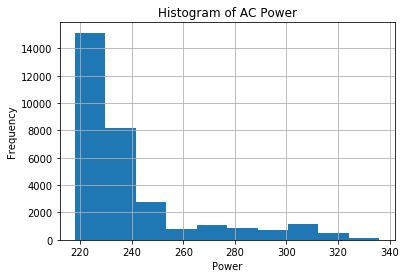

In [211]:
#Histogram of ac_power
df.ac_power.hist()
plt.title('Histogram of AC Power')
plt.xlabel('Power')
plt.ylabel('Frequency')

In [231]:
dfgb = df.groupby('ac_power').mean().reset_index()
print dfgb.columns

Index([u'ac_power', u'total-unhalted_core_cycles',
       u'total-instructions_retired', u'total-last_level_cache_references',
       u'total-memory_bus_transactions', u'total-cpu-utilization',
       u'total-disk-accesses', u'total-disk-blocks',
       u'total-disk-utilization'],
      dtype='object')


Text(0.5,0,u'CPU Utilization')

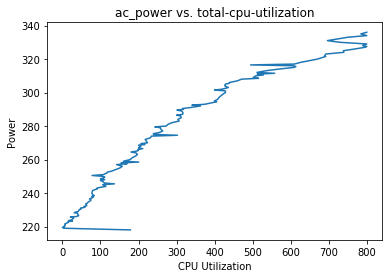

In [233]:
plt.plot(dfgb[['total-cpu-utilization']], dfgb[['ac_power']])
plt.title('ac_power vs. total-cpu-utilization')
plt.ylabel('Power')
plt.xlabel('CPU Utilization')

We can see a correlation between CPU Utilization and Power Consumption and it suggests that total-cpu-utilization is a feature to be taken into account

Text(0.5,0,u'total-memory_bus_transactions')

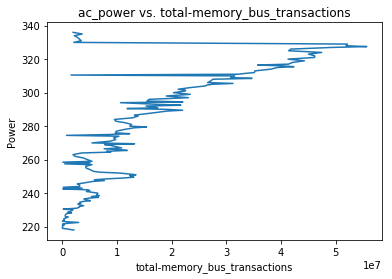

In [237]:
plt.plot(dfgb[['total-memory_bus_transactions']], dfgb[['ac_power']])
plt.title('ac_power vs. total-memory_bus_transactions')
plt.ylabel('Power')
plt.xlabel('total-memory_bus_transactions')

We can see a correlation between memory bus transaction and Power Consumption and it suggests that this is a feature to be taken into account

## Linear Regression

Let's go ahead and run linear regression on the entire data set, and see how accurate it is!

In [253]:
#prepare data for regression
X = df[['total-unhalted_core_cycles',\
        'total-instructions_retired',\
        'total-last_level_cache_references',\
        'total-memory_bus_transactions',\
        'total-cpu-utilization',\
        'total-disk-accesses',\
        'total-disk-blocks',\
        'total-disk-utilization']]
y = np.ravel(df[['ac_power']])

In [249]:
# instantiate a logistic regression model, and fit with X and y
model = LinearRegression()
model = model.fit(X, y)
# check the accuracy on the training set
model.score(X, y)

0.948176992087879

94.81% accuracy are pretty good. Let's examine the coefficients to see what we learn.

In [244]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,total-unhalted_core_cycles,[5.10234856789497e-09]
1,total-instructions_retired,[1.7554019695662733e-09]
2,total-last_level_cache_references,[2.3296168995270942e-08]
3,total-memory_bus_transactions,[6.92139769298097e-07]
4,total-cpu-utilization,[-0.07051821642442117]
5,total-disk-accesses,[-0.004039622955504849]
6,total-disk-blocks,[-0.00034822437554911617]
7,total-disk-utilization,[0.02769741819027014]


The first four features are associated with small coef. implying that they has little impact on the power consumption. The `total-disk-utilization` seems to have the most impact on the power (which makes sense).

## Model Evaluation Using a Validation Set

<i>Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally.</i>

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [254]:
# evaluate the model by splitting into train and test sets (70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LinearRegression()
model2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [255]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print predicted

[352.03756956 235.22189423 224.03963036 ... 227.77606598 231.28343736
 226.41632718]


In [259]:
from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print('Coefficients: \n', model2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, predicted))

('Coefficients: \n', array([ 5.80780582e-09,  1.49311369e-09,  1.98236830e-08,  6.01646728e-07,
       -6.97249386e-02, -3.45245314e-03, -3.66497908e-04,  2.82844944e-02]))
Mean squared error: 31.28
Variance score: 0.95


The variance score(RSquare) is 95% which is really good

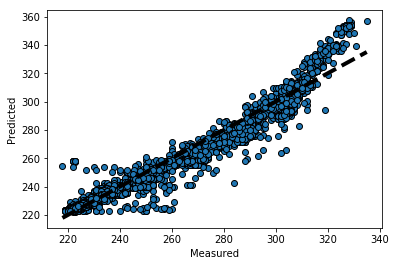

In [257]:
fig, ax = plt.subplots()
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

The plot shows that the model predicts very well the ac power (the points are very close to the `perfect line`)

## Cross-Validation
<i>When evaluating different settings (“hyperparameters”) for estimators, 
there is still a risk of overfitting on the test set because the parameters 
can be tweaked until the estimator performs optimally. 
This way, knowledge about the test set can “leak” into the model and evaluation 
metrics no longer report on generalization performance. 
To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: 
    training proceeds on the training set, after which evaluation is done on the validation set, 
    and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, 
we drastically reduce the number of samples which can be used for learning the model, 
and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). 
A test set should still be held out for final evaluation, 
but the validation set is no longer needed when doing CV. 
In the basic approach, called k-fold CV, the training set is split into 
k smaller sets (other approaches are described below, but generally follow the same principles). 
The following procedure is followed for each of the k “folds”:

        A model is trained using k-1 of the folds as training data;
        the resulting model is validated on the remaining part of the data 
        (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.</i>

In [263]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model2, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.51)


With 10-fold cross-validation, it's accuracy is 83%, which is quite good

## Conclusion & Future Work

In this showcase, I showed a typical Machine Learning algorithm (Linear Regression) in prediction of Power consumption. There are still rooms for improving this preditive model:
* regularization techniques
* using a non-linear model

### THANK YOU!!!